In [23]:
import logging
import random
from typing import Any

import numpy as np
import timm
import torch
import torchvision
from torch.utils.data import WeightedRandomSampler, BatchSampler
from torchvision.models import VisionTransformer

from sklearn import metrics

import wandb
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.axes import Axes
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision.transforms import v2

import hw2.utils.recursive_reload
%reload hw2
from hw2 import PROJECT_ROOT
from hw2.data.cifar100_lt import CIFAR100LT
from hw2.util import find_mean_and_stddev, validate_on_cifar, train_on_cifar
from hw2.visualization import visualize_images
from hw2.models.inception_v3 import get_inception_v3, get_inception_v3_transform

# CIFAR100(root=PROJECT_ROOT / "data", train=True, download=True, transform=None)

reloaded module: hw2


In [2]:
%reload hw2

reloaded module: hw2


In [3]:
dataset = CIFAR100LT(root=PROJECT_ROOT / "data", train=True, imb_type='exp', imb_factor=0.01, download=True, transform=None)
dataset

Files already downloaded and verified


Dataset CIFAR100LT
    Number of datapoints: 10899
    Root location: D:\Code\CISC3027\hw2\data
    Split: Train

In [4]:
dataset.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, np.int64(0))

In [6]:
dataset.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [7]:
samples = dataset.get_superclass_sample()

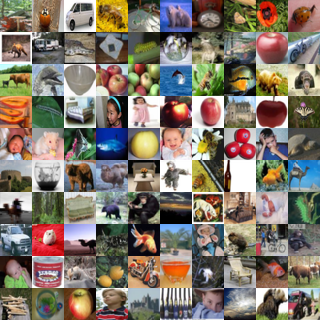

In [8]:
rand_images = random.choices(dataset, k=100)
visualize_images([img for img, _target in rand_images], show=False)

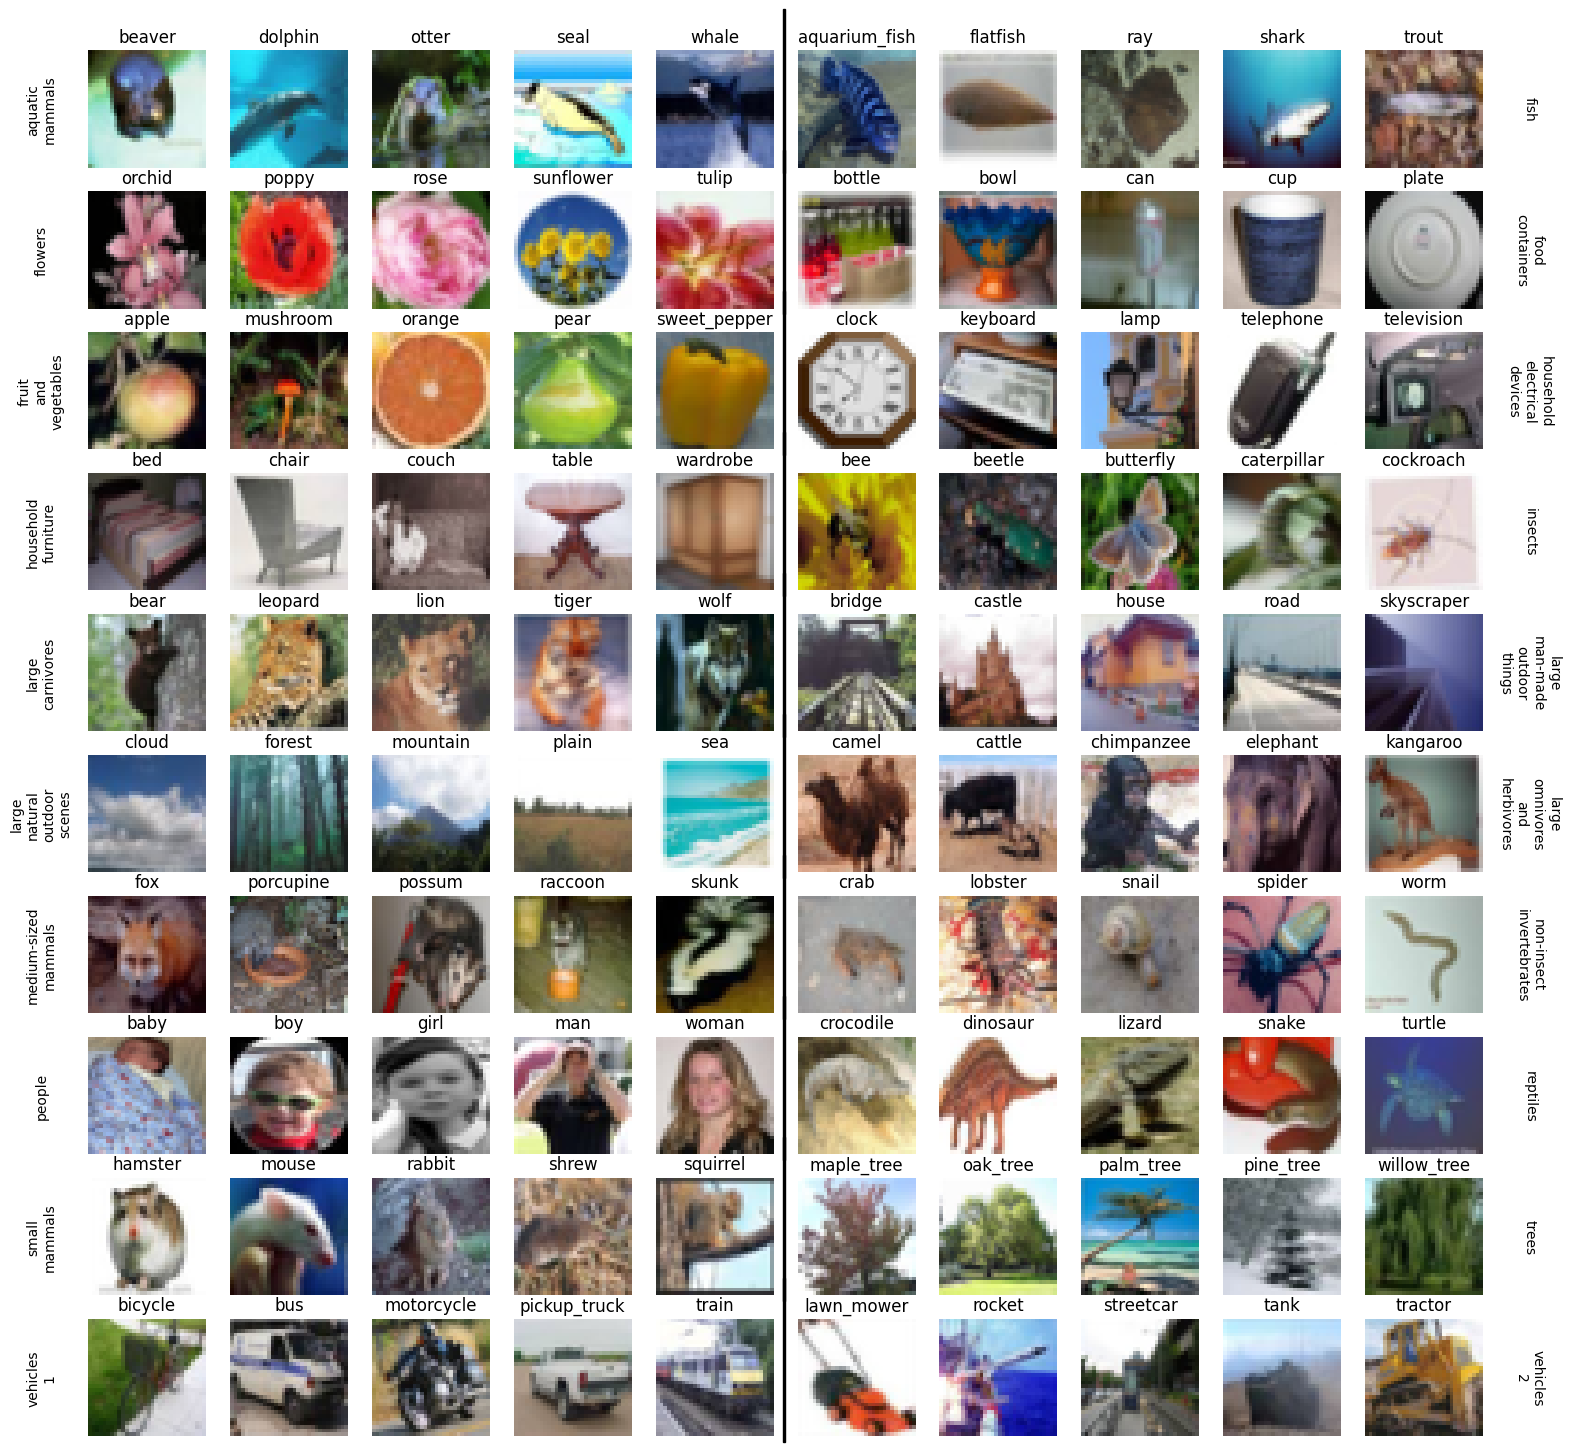

In [9]:
fig, axes = plt.subplots(10, 10, figsize=(18, 18))


for i, (cls, superclass_samples) in enumerate(samples.items()):
    for j, img in enumerate(superclass_samples):
        axes[i // 2, j + 5 * (i % 2)].imshow(img)
        axes[i // 2, j + 5 * (i % 2)].axis("off")
        axes[i // 2, j + 5 * (i % 2)].set_title(dataset.superclass_to_class[cls][j])

    # Format the superclass name to split words into separate lines, because the graph has overlapping text without this
    formatted_superclass = "\n".join(cls.split())

    # Add superclass labels
    if i % 2 == 0:  # Left side
        axes[i // 2, 0].annotate(
            formatted_superclass,
            xy=(-0.4, 0.5),
            xycoords="axes fraction",
            fontsize=10,
            ha="center",
            va="center",
            rotation=90,
            wrap=True,
        )
    else:  # Right side
        axes[i // 2, 9].annotate(
            formatted_superclass,
            xy=(1.4, 0.5),
            xycoords="axes fraction",
            fontsize=10,
            ha="center",
            va="center",
            rotation=270,
            wrap=True,
        )

for ax_row in axes:
    ax_row[4].add_patch(
        patches.Rectangle(
            xy=(1.08, -0.05),
            width=0.02,
            height=1.4,
            transform=ax_row[4].transAxes,
            color="black",
            clip_on=False,
        )
    )

plt.savefig(PROJECT_ROOT / "artifacts" / "CIFAR100_grid_visualization.svg")

In [10]:
type(axes), type(axes[0]), type(axes[0, 0])

(numpy.ndarray, numpy.ndarray, matplotlib.axes._axes.Axes)

In [11]:
find_mean_and_stddev(dataset)

PIL images are supported, but you may want to convert them to float tensors for actual use.


((133.415771484375, 125.77626037597656, 113.08790588378906),
 (68.47135162353516, 66.58660125732422, 70.72967529296875))

In [12]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
dataset = CIFAR100LT(root=PROJECT_ROOT / "data", train=True, imb_type='exp', imb_factor=0.01, download=True, transform=transform)

Files already downloaded and verified


In [13]:
find_mean_and_stddev(dataset)

((0.522575855255127, 0.493937224149704, 0.4434146285057068),
 (0.26896438002586365, 0.26174917817115784, 0.2781769931316376))

In [14]:
from functools import partial

tuple(map(lambda x: tuple(map(partial(round, ndigits=4), x)), find_mean_and_stddev(dataset)))

((0.5226, 0.4939, 0.4434), (0.269, 0.2617, 0.2782))

In [34]:
from hw2.models.cnn_basic import LeNet5

# model = LeNet5(channels=3, n_classes=100)
model = torchvision.models.resnet50(num_classes=100)
# model = get_inception_v3(num_classes=100)

In [35]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
epochs = 320
learning_rate = 0.001
batch_size = 64

class_weights = 1 / torch.tensor(dataset.img_num_per_cls)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
sample_weights = [class_weights[target] for target in dataset.targets]
sampler = BatchSampler(WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True), batch_size=64, drop_last=False)

# criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

In [36]:
list(sampler)[0][:15]

[8029,
 10623,
 8558,
 10304,
 10608,
 10254,
 7621,
 9733,
 9385,
 9386,
 10741,
 10672,
 813,
 8995,
 10871]

In [37]:
run = wandb.init(
    project="CISC3027 hw3",
    group=None,
    job_type="train",
    config={
        "model_type": "CNN",
        "model": "ResNet-50",
        "epochs": epochs,
        "optimizer": optimizer.__class__.__name__,
        "lr_scheduler": scheduler.__class__.__name__,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "device": device,
        "dataset": "CIFAR100LT"
    }
)

logging.basicConfig(level=logging.INFO, force=True)

# train
train_on_cifar(model, optimizer, criterion, scheduler, CIFAR100LT.basic_train_transform, epochs, device, log_run=True, cifar_dataset="CIFAR100LT", n_test_samples=10000, batch_sampler=sampler)


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test/accuracy,▁▁▂▃▃▅▄▅▅▆▆▆▆▇▆▆▇▆▇▆▇▇▇█▇▇▇▇▇██▇▇▇▇█▇▇▇█
test/loss,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▆▇▇█▇▇▇▇█
train/accuracy,▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇████████
train/loss,█▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,41
test/accuracy,0.0973
test/loss,9.96659
train/accuracy,0.41123
train/loss,0.81558


Files already downloaded and verified
Files already downloaded and verified


INFO:hw2.util:Epoch 0, Batch 0, Loss: 4.7698
INFO:hw2.util:Epoch 0, Batch 7, Loss: 6.4186
INFO:hw2.util:Epoch 0, Batch 14, Loss: 5.0655
INFO:hw2.util:Epoch 0, Batch 21, Loss: 4.5038
INFO:hw2.util:Epoch 0, Batch 28, Loss: 4.4138
INFO:hw2.util:Epoch 0, Batch 35, Loss: 5.0067
INFO:hw2.util:Epoch 0, Batch 42, Loss: 5.5678
INFO:hw2.util:Epoch 0, Batch 49, Loss: 4.3826
INFO:hw2.util:Epoch 0, Batch 56, Loss: 4.1993
INFO:hw2.util:Epoch 0, Batch 63, Loss: 4.6711
INFO:hw2.util:Epoch 0, Batch 70, Loss: 3.9937
INFO:hw2.util:Epoch 0, Batch 77, Loss: 4.0272
INFO:hw2.util:Epoch 0, Batch 84, Loss: 3.9505
INFO:hw2.util:Epoch 0, Batch 91, Loss: 5.6102
INFO:hw2.util:Epoch 0, Batch 98, Loss: 3.9852
INFO:hw2.util:Epoch 0, Batch 105, Loss: 4.6091
INFO:hw2.util:Epoch 0, Batch 112, Loss: 4.7114
INFO:hw2.util:Epoch 0, Batch 119, Loss: 4.9382
INFO:hw2.util:Epoch 0, Batch 126, Loss: 3.8158
INFO:hw2.util:Epoch 0, Batch 133, Loss: 4.2688
INFO:hw2.util:Epoch 0, Batch 140, Loss: 3.8731
INFO:hw2.util:Epoch 0, Batch 1

(30.242378935029237, 0.1461)

In [40]:
run.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test/accuracy,▁▂▃▄▅▅▅▅▆▆▆▅▆▆▆▆▇▇▇▇▇▆▇▅███▇▇█
test/loss,▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇█████
train/accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇██████
train/loss,█▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
test/accuracy,0.104
test/loss,19.8696
train/accuracy,0.61143
train/loss,0.27397


In [38]:
from pprint import pp

results = validate_on_cifar(model, criterion, CIFAR100LT.basic_test_transform, device, additional_metrics=[partial(metrics.classification_report, digits=4, zero_division=0)], cifar_dataset="100LT")
print(results["classification_report"])

Files already downloaded and verified


INFO:hw2.util:Validation loss: 34.716773986816406, accuracy: 0.1468, classification_report:               precision    recall  f1-score   support

           0     0.2042    0.6800    0.3141       100
           1     0.1355    0.6300    0.2230       100
           2     0.1029    0.4300    0.1660       100
           3     0.0624    0.2900    0.1027       100
           4     0.0518    0.2900    0.0879       100
           5     0.0741    0.3400    0.1216       100
           6     0.1036    0.4000    0.1646       100
           7     0.0860    0.3700    0.1396       100
           8     0.0990    0.3800    0.1570       100
           9     0.1390    0.3600    0.2006       100
          10     0.0391    0.1100    0.0577       100
          11     0.1244    0.2400    0.1638       100
          12     0.1144    0.3900    0.1769       100
          13     0.0796    0.2300    0.1183       100
          14     0.0625    0.1400    0.0864       100
          15     0.0729    0.1800    0.1037

              precision    recall  f1-score   support

           0     0.2042    0.6800    0.3141       100
           1     0.1355    0.6300    0.2230       100
           2     0.1029    0.4300    0.1660       100
           3     0.0624    0.2900    0.1027       100
           4     0.0518    0.2900    0.0879       100
           5     0.0741    0.3400    0.1216       100
           6     0.1036    0.4000    0.1646       100
           7     0.0860    0.3700    0.1396       100
           8     0.0990    0.3800    0.1570       100
           9     0.1390    0.3600    0.2006       100
          10     0.0391    0.1100    0.0577       100
          11     0.1244    0.2400    0.1638       100
          12     0.1144    0.3900    0.1769       100
          13     0.0796    0.2300    0.1183       100
          14     0.0625    0.1400    0.0864       100
          15     0.0729    0.1800    0.1037       100
          16     0.1667    0.2800    0.2090       100
          17     0.1854    

In [39]:
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "cifar100lt" / f"resnet50_{results["accuracy"]}_weight_balanced.pth")

In [40]:
model = timm.create_model("timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k", pretrained=True)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=100)
# 20 blocks in total
# Freeze all layers except the head and the last 2 blocks
for name, param in model.named_parameters():
    # print(name)
    if "head" in name or name.startswith("blocks.19") or "fc_norm" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k)
INFO:timm.models._hub:[timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
epochs = 320
learning_rate = 0.001
batch_size = 64

# class_weights = 1 / torch.tensor(dataset.img_num_per_cls)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# sample_weights = [class_weights[target] for target in dataset.targets]
# sampler = BatchSampler(WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True), batch_size=64, drop_last=False)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [42]:
run = wandb.init(
    project="CISC3027 hw3",
    group=None,
    job_type="train",
    config={
        "model_type": "ViT",
        "model": "vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k",
        "epochs": epochs,
        "optimizer": optimizer.__class__.__name__,
        "lr_scheduler": scheduler.__class__.__name__,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "device": device,
        "dataset": "CIFAR100LT"
    }
)

logging.basicConfig(level=logging.INFO, force=True)

# train
train_on_cifar(model, optimizer, criterion, scheduler, transforms, epochs, device, log_run=True, cifar_dataset="CIFAR100LT", n_test_samples=10000)

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█
test/accuracy,▁▁▂▃▄▅▅▅▅▅▇▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇█▇███▇██▇▇█▇▇
test/loss,▁▁▁▁▂▂▃▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▄▅▅▆▆▇▇▇▇▇█████
train/accuracy,▁▂▂▂▄▃▃▄▃▄▅▅▆▅▅▇▆▇▆▇▇▇▇▇▇▇▇█▇███████████
train/loss,█▇▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,319
test/accuracy,0.1461
test/loss,30.24238
train/accuracy,0.99688
train/loss,0.00113


Files already downloaded and verified
Files already downloaded and verified


INFO:hw2.util:Epoch 0, Batch 0, Loss: 7.1562
INFO:hw2.util:Epoch 0, Batch 7, Loss: 2.2230
INFO:hw2.util:Epoch 0, Batch 14, Loss: 1.7817
INFO:hw2.util:Epoch 0, Batch 21, Loss: 1.5240
INFO:hw2.util:Epoch 0, Batch 28, Loss: 0.7769
INFO:hw2.util:Epoch 0, Batch 35, Loss: 1.0476
INFO:hw2.util:Epoch 0, Batch 42, Loss: 1.1546
INFO:hw2.util:Epoch 0, Batch 49, Loss: 0.8606
INFO:hw2.util:Epoch 0, Batch 56, Loss: 0.7023
INFO:hw2.util:Epoch 0, Batch 63, Loss: 0.7371
INFO:hw2.util:Epoch 0, Batch 70, Loss: 0.8358
INFO:hw2.util:Epoch 0, Batch 77, Loss: 1.0991
INFO:hw2.util:Epoch 0, Batch 84, Loss: 0.7161
INFO:hw2.util:Epoch 0, Batch 91, Loss: 0.6750
INFO:hw2.util:Epoch 0, Batch 98, Loss: 1.0305
INFO:hw2.util:Epoch 0, Batch 105, Loss: 0.6129
INFO:hw2.util:Epoch 0, Batch 112, Loss: 0.6372
INFO:hw2.util:Epoch 0, Batch 119, Loss: 0.5859
INFO:hw2.util:Epoch 0, Batch 126, Loss: 0.4264
INFO:hw2.util:Epoch 0, Batch 133, Loss: 0.5714
INFO:hw2.util:Epoch 0, Batch 140, Loss: 0.7637
INFO:hw2.util:Epoch 0, Batch 1

(1.4178980819032163, 0.7399)

In [43]:
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "cifar100lt" / f"vit_{results["accuracy"]}_epochs8.5.pth")

In [44]:
results

{'loss': 34.716773986816406,
 'accuracy': 0.1468,
 'classification_report': '              precision    recall  f1-score   support\n\n           0     0.2042    0.6800    0.3141       100\n           1     0.1355    0.6300    0.2230       100\n           2     0.1029    0.4300    0.1660       100\n           3     0.0624    0.2900    0.1027       100\n           4     0.0518    0.2900    0.0879       100\n           5     0.0741    0.3400    0.1216       100\n           6     0.1036    0.4000    0.1646       100\n           7     0.0860    0.3700    0.1396       100\n           8     0.0990    0.3800    0.1570       100\n           9     0.1390    0.3600    0.2006       100\n          10     0.0391    0.1100    0.0577       100\n          11     0.1244    0.2400    0.1638       100\n          12     0.1144    0.3900    0.1769       100\n          13     0.0796    0.2300    0.1183       100\n          14     0.0625    0.1400    0.0864       100\n          15     0.0729    0.1800    0.10